In [91]:
import pandas as pd
import requests, json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### 自動生成 24 個月份的列表，從 2021 年 1 月開始

In [92]:
def generate_date_list(start_date, months):
    date_list = []
    start = datetime.strptime(start_date, "%Y%m%d")
    for i in range(months):
        year_month = start + timedelta(days=30 * i)  # 每次增加一個月
        date_str = year_month.strftime("%Y%m01")  # 每個月的第一天
        date_list.append(date_str)
    return date_list

### 下載證交所資料

In [93]:
def fetch_data(date, stock_no):
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_no}'
    html = requests.get(url,verify=False)
    content = json.loads(html.text)
    stock_data = content['data']
    col_name = content['fields']
    df = pd.DataFrame(data=stock_data, columns=col_name)
    return df

### 將民國年轉換為西元年

In [94]:
def convert_minguo_to_ad(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)
    return f'{year}-{month}-{day}'

### 爬取證交所 2330.tw 股價

In [95]:
# 生成 36 個月份的日期列表
date_list = generate_date_list('20210601', 36)
stock_no = '2330'
df_list = []

for date in date_list:
    df = fetch_data(date, stock_no)
    df_list.append(df)

# 將多個月份的資料合併，只使用前 35 個月資料
df_twse = pd.concat(df_list[:-1])

# 將日期轉換為西元年
df_twse['日期'] = df_twse['日期'].apply(convert_minguo_to_ad)
# 轉換為 datetime 格式並設置為索引
df_twse['日期'] = pd.to_datetime(df_twse['日期'], format='%Y-%m-%d')
df_twse.set_index('日期', inplace=True)

df_twse.tail()

d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverif

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
2024-03-25,"21,223,414","16,612,693,369",783.00,788.00,779.00,780.00,-5.00,"24,794"
2024-03-26,"43,103,294","33,847,261,033",788.00,792.00,776.00,782.00,+2.00,"35,046"
2024-03-27,"19,732,209","15,418,346,943",785.00,785.00,779.00,779.00,-3.00,"21,006"
2024-03-28,"28,393,398","21,889,883,699",774.00,776.00,768.00,769.00,-10.00,"39,848"
2024-03-29,"20,212,820","15,682,908,766",769.00,781.00,768.00,779.00,+10.00,"18,110"


### 修正表格部分欄位資料型態並轉換為數字型態

In [96]:
df_twse['開盤價'] = pd.to_numeric(df_twse['開盤價'].str.replace(',', ''), errors='coerce')
df_twse['收盤價'] = pd.to_numeric(df_twse['收盤價'].str.replace(',', ''), errors='coerce')
df_twse['最高價'] = pd.to_numeric(df_twse['最高價'].str.replace(',', ''), errors='coerce')
df_twse['最低價'] = pd.to_numeric(df_twse['最低價'].str.replace(',', ''), errors='coerce')

### 1. 計算技術指標（SMA、RSI、MACD）

In [97]:
# RSI 計算
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [98]:
# 計算SMA (簡單移動平均)
df_twse['SMA_20'] = df_twse['收盤價'].rolling(window=20).mean()

# 計算 RSI
df_twse['RSI_14'] = calculate_rsi(df_twse['收盤價'])

# 計算MACD
short_window = 12
long_window = 26
signal_window = 9
df_twse['EMA12'] = df_twse['收盤價'].ewm(span=short_window, adjust=False).mean()
df_twse['EMA26'] = df_twse['收盤價'].ewm(span=long_window, adjust=False).mean()
df_twse['MACD'] = df_twse['EMA12'] - df_twse['EMA26']
df_twse['MACD_Signal'] = df_twse['MACD'].ewm(span=signal_window, adjust=False).mean()
df_twse.tail()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_20,RSI_14,EMA12,EMA26,MACD,MACD_Signal
日期,,,,,,,,,,,,,,
2024-03-25,"21,223,414","16,612,693,369",783.0,788.0,779.0,780.0,-5.00,"24,794",749.70,64.705882,765.083765,735.688622,29.395143,31.279271
2024-03-26,"43,103,294","33,847,261,033",788.0,792.0,776.0,782.0,+2.00,"35,046",753.90,64.071856,767.686263,739.119094,28.567169,30.736851
2024-03-27,"19,732,209","15,418,346,943",785.0,785.0,779.0,779.0,-3.00,"21,006",757.95,56.551724,769.426838,742.073235,27.353602,30.060201
2024-03-28,"28,393,398","21,889,883,699",774.0,776.0,768.0,769.0,-10.00,"39,848",761.90,44.274809,769.361170,744.067811,25.293360,29.106833
2024-03-29,"20,212,820","15,682,908,766",769.0,781.0,768.0,779.0,+10.00,"18,110",766.40,55.284553,770.844067,746.655380,24.188687,28.123204


In [99]:
# 將欄位名稱改為英文
df_twse.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close', '成交筆數': 'Volume'}, inplace=True)
# 移除有 NaN 值的列
df_twse.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_twse['Volume'] = pd.to_numeric(df_twse['Volume'].str.replace(',', ''), errors='coerce')

### 2.可視化 K 線圖

C:\Users\謝孟達\AppData\Local\Temp\ipykernel_18408\3467740012.py:15: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_recent_six_months = df_twse.last("3ME")


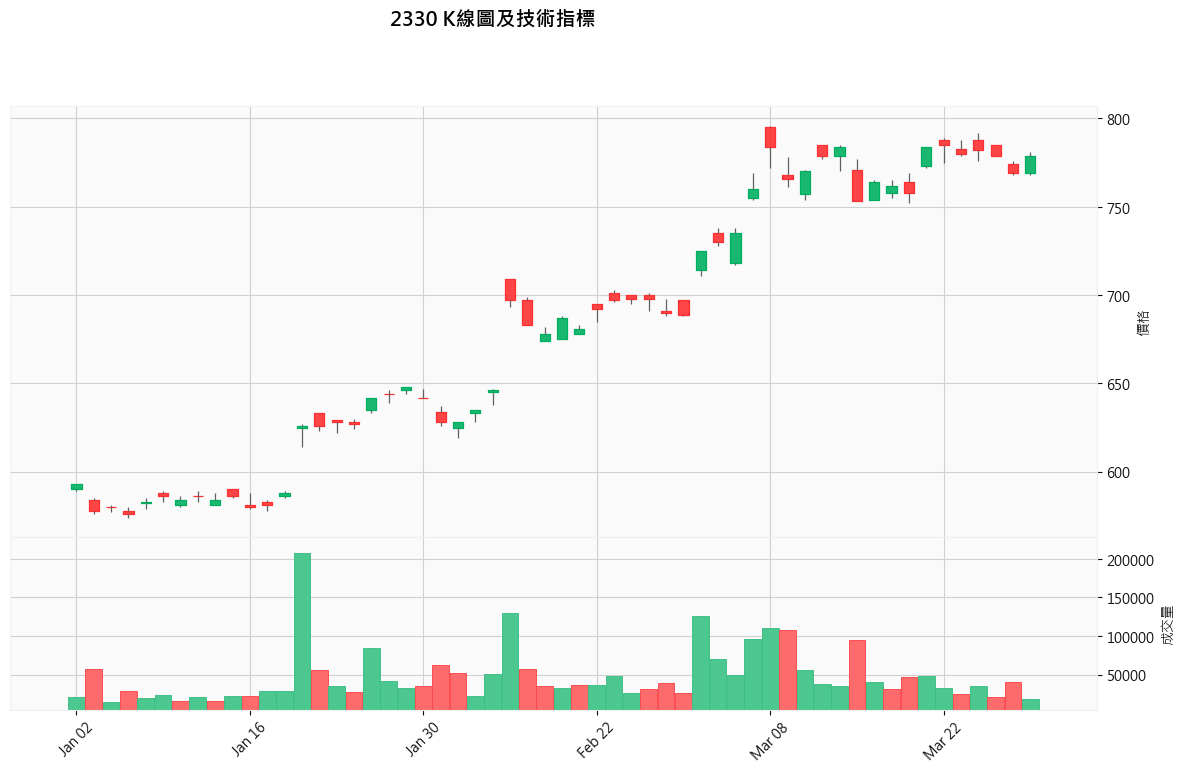

In [100]:
import mplfinance as mpf

# 設定字體為 Microsoft JhengHei
s = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.family': 'Microsoft JhengHei', 'axes.unicode_minus': 'False'})
# 將欄位名稱改為英文
df_twse.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close', '成交筆數': 'Volume'}, inplace=True)
# 移除有 NaN 值的列
df_twse.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_twse['Volume'] = df_twse['Volume'].astype(float)

# 準備 K 線圖所需的資料
df_candle = df_twse[['Open', 'High', 'Low', 'Close', 'Volume']]

# 選取最後六個月的資料
df_recent_six_months = df_twse.last("3ME")

# 繪製 K 線圖，並疊加 SMA
Kbar_plt, axes = mpf.plot(df_recent_six_months, type='candle', style=s, volume=True, 
         title=f'{stock_no} K線圖及技術指標', ylabel='價格', ylabel_lower='成交量', figratio=(14, 8), figscale=1.5, returnfig=True)

Kbar_plt.savefig('Kbar.png')

### 3.技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

In [101]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [102]:
# 移除 NaN 值
df_twse.dropna(subset=['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal'], inplace=True)

# 建立未來一天的股價作為目標變量
df_twse['Future_Price'] = df_twse['Close'].shift(-1)
# 使用第36個月的第一個資料填補最後一天空值
df_36th_month = df_list[-1]
first_price_of_36th_month = float(df_36th_month.iloc[0]['收盤價'].replace(',', ''))
df_twse['Future_Price'].iloc[-1] = first_price_of_36th_month

# 準備特徵和標籤
X = df_twse[['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal']]
y = df_twse['Future_Price']

# 分割資料為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 機器學習模型：線性回歸、決策樹、隨機森林
# 1. 線性回歸
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. 決策樹回歸
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# 3. 隨機森林回歸
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

C:\Users\謝孟達\AppData\Local\Temp\ipykernel_18408\1548870016.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_twse['Future_Price'].iloc[-1] = first_price_of_36th_month
C:\Users\謝孟達\AppData\Local\Temp\ipykernel_18408\1548870016.py:9: Sett

### 計算相對準確率

In [103]:
# 計算相對準確率（1 - MAPE）
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
mape_tree = mean_absolute_percentage_error(y_test, y_pred_tree)
mape_forest = mean_absolute_percentage_error(y_test, y_pred_forest)

accuracy_lr = 1 - mape_lr
accuracy_tree = 1 - mape_tree
accuracy_forest = 1 - mape_forest

print(f"線性回歸相對準確率: {accuracy_lr * 100:.2f}%")
print(f"決策樹相對準確率: {accuracy_tree * 100:.2f}%")
print(f"隨機森林相對準確率: {accuracy_forest * 100:.2f}%")

線性回歸相對準確率: 98.43%
決策樹相對準確率: 98.23%
隨機森林相對準確率: 98.54%


### 股價預測圖

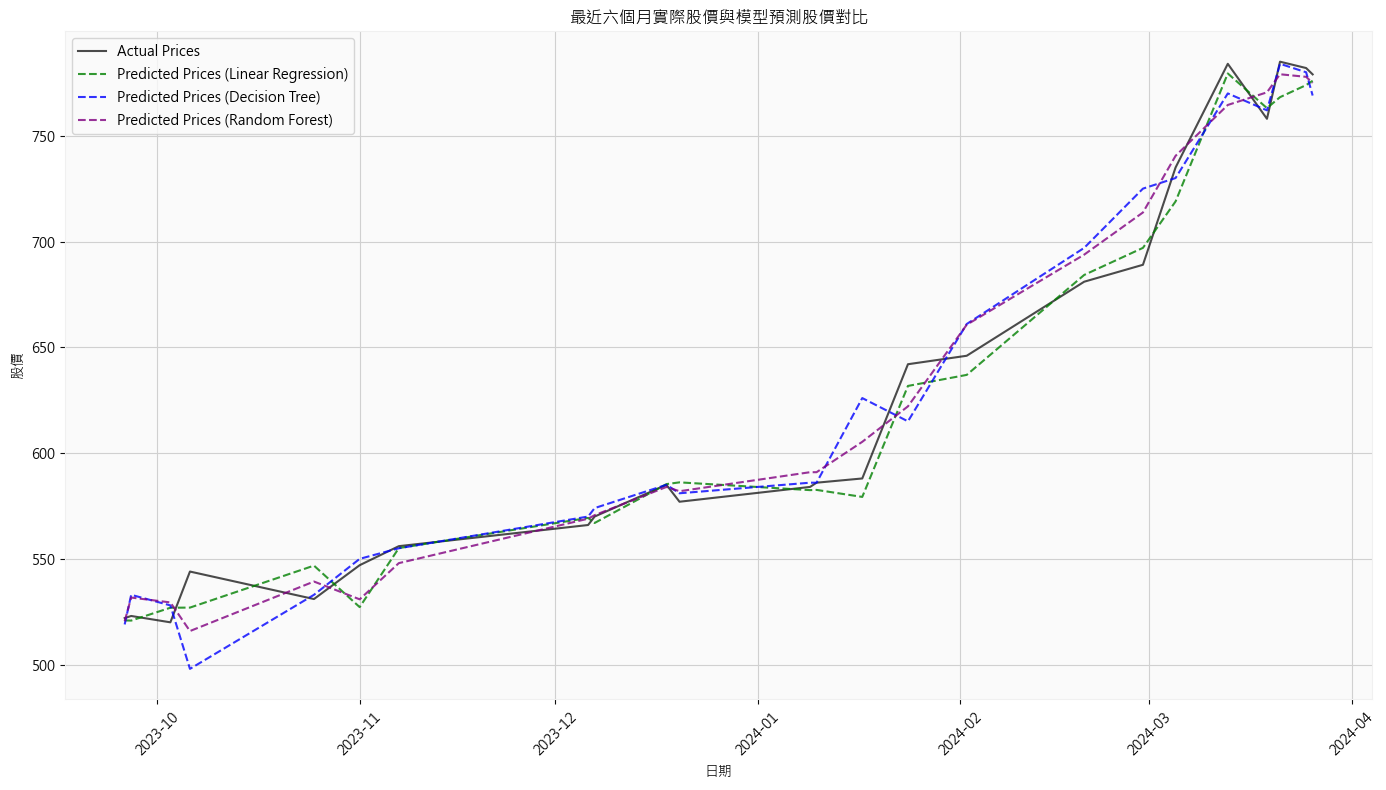

In [104]:
# 只取最近六個月的回測結果
dates = y_test.index  # 測試集對應的日期
six_months_ago = dates.max() - pd.DateOffset(months=6)  # 六個月前的日期
recent_six_months = dates[dates >= six_months_ago]  # 取出最近六個月的日期範圍

# 只顯示最近六個月的實際股價和預測股價
y_test_recent = y_test.loc[recent_six_months]
y_pred_lr_recent = pd.Series(y_pred_lr, index=y_test.index).loc[recent_six_months]
y_pred_tree_recent = pd.Series(y_pred_tree, index=y_test.index).loc[recent_six_months]
y_pred_forest_recent = pd.Series(y_pred_forest, index=y_test.index).loc[recent_six_months]

# 確保索引按時間順序排列
y_test_recent = y_test_recent.sort_index()
y_pred_lr_recent = y_pred_lr_recent.sort_index()
y_pred_tree_recent = y_pred_tree_recent.sort_index()
y_pred_forest_recent = y_pred_forest_recent.sort_index()

# 繪製最近六個月的預測結果與實際股價對比
plt.figure(figsize=(14, 8))

# 繪製實際股價曲線
plt.plot(y_test_recent.index, y_test_recent, label='Actual Prices', color='black', alpha=0.7)

# 繪製線性回歸預測結果
plt.plot(y_pred_lr_recent.index, y_pred_lr_recent, label='Predicted Prices (Linear Regression)', color='green', linestyle='--', alpha=0.8)

# 繪製決策樹預測結果
plt.plot(y_pred_tree_recent.index, y_pred_tree_recent, label='Predicted Prices (Decision Tree)', color='blue', linestyle='--', alpha=0.8)

# 繪製隨機森林預測結果
plt.plot(y_pred_forest_recent.index, y_pred_forest_recent, label='Predicted Prices (Random Forest)', color='purple', linestyle='--', alpha=0.8)

# 添加圖例和標題
plt.title('最近六個月實際股價與模型預測股價對比')
plt.xlabel('日期')
plt.ylabel('股價')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 保存圖表到 PNG 文件
plt.savefig('stock_pred_6.png')

# 顯示圖表
plt.show()